In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [2]:
btc = pd.read_csv('/Users/nikita/Desktop/monero/BTC.csv', sep=',', encoding='utf-8')

In [3]:
btc.columns = ['date', 'close', 'high', 'low', 'open', 'volume', '%']

In [4]:
btc['close'] = btc['close'].str.replace('.', '')
btc['high'] = btc['high'].str.replace('.', '')
btc['low'] = btc['low'].str.replace('.', '')
btc['open'] = btc['open'].str.replace('.', '')
btc['volume'] = btc['volume'].str.replace('.', '')
btc['%'] = btc['%'].str.replace('.', '')
btc['%'] = btc['%'].str.replace('%', '') 

btc['close'] = btc['close'].str.replace(',', '.').astype(float)
btc['high'] = btc['high'].str.replace(',', '.').astype(float)
btc['low'] = btc['low'].str.replace(',', '.').astype(float)
btc['open'] = btc['open'].str.replace(',', '.').astype(float)
btc['volume'] = btc['volume'].str.replace(',', '.')  # Remove commas
btc['%'] = btc['%'].str.replace(',', '.').astype(float)


btc['volume'] = btc['volume'].str.replace('K', 'e3')  # Replace 'K' with 'e3'
btc['volume'] = btc['volume'].str.replace('M', 'e6')  # Replace 'M' with 'e6'
btc['volume'] = btc['volume'].str.replace('B', 'e9')  # Replace 'B' with 'e9'
btc['volume'] = btc['volume'].astype(float)  # Convert to float

In [5]:
btc = btc.iloc[::-1].reset_index(drop=True)
btc = btc.set_index('date')
btc.index = pd.to_datetime(btc.index)

/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_17015/3883492016.py:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  btc.index = pd.to_datetime(btc.index)


In [6]:
btc

close     high      low     open   volume     %
date                                                         
2012-09-27     12.3     12.3     12.4     12.2  19330.0  0.00
2012-09-28     12.4     12.3     12.4     12.1  26680.0  0.65
2012-09-29     12.4     12.4     12.5     12.2  17060.0  0.00
2012-09-30     12.4     12.4     12.4     12.3   7790.0  0.00
2012-10-01     12.4     12.4     12.5     12.3  24830.0  0.00
...             ...      ...      ...      ...      ...   ...
2025-04-23  93697.7  93442.2  94462.6  91963.4  90350.0  0.27
2025-04-24  93980.3  93696.3  94001.0  91673.0  66680.0  0.30
2025-04-25  94676.9  93979.4  95718.6  92867.2  92040.0  0.74
2025-04-26  94631.4  94669.3  95207.0  93891.8  33770.0 -0.05
2025-04-27  93873.1  94631.4  95324.4  93640.7  35890.0 -0.80

[4596 rows x 6 columns]

### Создание новых признаков

In [7]:
btc

close     high      low     open   volume     %
date                                                         
2012-09-27     12.3     12.3     12.4     12.2  19330.0  0.00
2012-09-28     12.4     12.3     12.4     12.1  26680.0  0.65
2012-09-29     12.4     12.4     12.5     12.2  17060.0  0.00
2012-09-30     12.4     12.4     12.4     12.3   7790.0  0.00
2012-10-01     12.4     12.4     12.5     12.3  24830.0  0.00
...             ...      ...      ...      ...      ...   ...
2025-04-23  93697.7  93442.2  94462.6  91963.4  90350.0  0.27
2025-04-24  93980.3  93696.3  94001.0  91673.0  66680.0  0.30
2025-04-25  94676.9  93979.4  95718.6  92867.2  92040.0  0.74
2025-04-26  94631.4  94669.3  95207.0  93891.8  33770.0 -0.05
2025-04-27  93873.1  94631.4  95324.4  93640.7  35890.0 -0.80

[4596 rows x 6 columns]

In [8]:
btc['close'] = btc['close'].shift(-1)
btc['open'] = btc['open'].shift(-1)

In [9]:
df_new = btc.copy()

In [10]:
# Заполняем NaN (например, 0 или оставляем как есть)
btc = btc.dropna()

df_new

close     high      low     open   volume     %
date                                                         
2012-09-27     12.4     12.3     12.4     12.1  19330.0  0.00
2012-09-28     12.4     12.3     12.4     12.2  26680.0  0.65
2012-09-29     12.4     12.4     12.5     12.3  17060.0  0.00
2012-09-30     12.4     12.4     12.4     12.3   7790.0  0.00
2012-10-01     12.8     12.4     12.5     12.3  24830.0  0.00
...             ...      ...      ...      ...      ...   ...
2025-04-23  93980.3  93442.2  94462.6  91673.0  90350.0  0.27
2025-04-24  94676.9  93696.3  94001.0  92867.2  66680.0  0.30
2025-04-25  94631.4  93979.4  95718.6  93891.8  92040.0  0.74
2025-04-26  93873.1  94669.3  95207.0  93640.7  33770.0 -0.05
2025-04-27      NaN  94631.4  95324.4      NaN  35890.0 -0.80

[4596 rows x 6 columns]

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data.index.day
    data_new['dayofweek'] = data.index.dayofweek
    data_new['month'] = data.index.month

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['%'].shift(lag)

    data_new['rolling_mean'] = data_new['%'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [12]:
df_new = make_features(df_new, max_lag = 28, rolling_mean_size = 50)
df_new.head()

close  high   low  open   volume     %  day  dayofweek  month  \
date                                                                        
2012-09-27   12.4  12.3  12.4  12.1  19330.0  0.00   27          3      9   
2012-09-28   12.4  12.3  12.4  12.2  26680.0  0.65   28          4      9   
2012-09-29   12.4  12.4  12.5  12.3  17060.0  0.00   29          5      9   
2012-09-30   12.4  12.4  12.4  12.3   7790.0  0.00   30          6      9   
2012-10-01   12.8  12.4  12.5  12.3  24830.0  0.00    1          0     10   

            lag_1  ...  lag_20  lag_21  lag_22  lag_23  lag_24  lag_25  \
date               ...                                                   
2012-09-27    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2012-09-28   0.00  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2012-09-29   0.65  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2012-09-30   0.00  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2012-10-01   0.00  ...     NaN     NaN     NaN     NaN     NaN     NaN   

            lag_26  lag_27  lag_28  rolling_mean  
date                                              
2012-09-27     NaN     NaN     NaN           NaN  
2012-09-28     NaN     NaN     NaN           NaN  
2012-09-29     NaN     NaN     NaN           NaN  
2012-09-30     NaN     NaN     NaN           NaN  
2012-10-01     NaN     NaN     NaN           NaN  

[5 rows x 38 columns]

In [13]:
df_new = df_new.dropna()

In [14]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.01)
train = train.dropna()

print(train.shape)

print(test.shape)
print(train.index.min(), train.index.max())

print(test.index.min(), test.index.max())

(4499, 38)
(46, 38)
2012-11-16 00:00:00 2025-03-11 00:00:00
2025-03-12 00:00:00 2025-04-26 00:00:00


In [15]:
X_train = train.drop(['close'], axis=1)
y_train = train['close']

X_test = test.drop(['close'], axis=1)
y_test = test['close']

## Обучение моделей

In [16]:
def calculate_metrics(y_true, y_pred):
    """Calculates MSE, RMSE, MAE, and MAPE."""

    mse = np.mean(np.square(y_true - y_pred))
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    # Handle potential division by zero in MAPE calculation
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    mape = np.nan_to_num(mape) #Replaces nan with 0

    return mse, rmse, mae, mape


In [17]:
# Словать с метриками для обучения моделей
scoring = {
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error'
}

In [18]:
# Определяем тип кросс-валидаци на временных рядах
tscv = TimeSeriesSplit(n_splits=10)

In [19]:
model = LinearRegression()

In [20]:
start_time = time.time()

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

lr_time = time.time() - start_time

In [21]:
y_predict = pd.Series(y_predict, index=X_test.index)

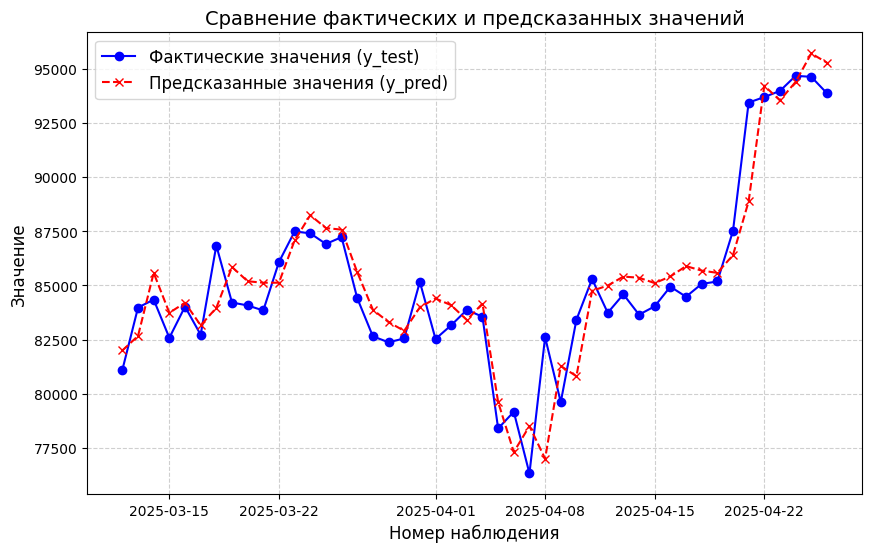

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(y_predict, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# Добавляем заголовки и легенду
plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [23]:
def accuracy(y_test, y_predict):
    y_test = y_test - y_test.shift(fill_value=0)
    y_predict = y_predict - pd.Series(y_predict).shift(fill_value=0)


    y_true = (y_test > 0).astype(int)
    y_pred = (y_predict > 0).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [24]:
accuracy(y_test, y_predict)

0.5652173913043478

Elastic

In [25]:
# Используем GridSearch для подбора гиперпараметров модели
param_grid = {
    'alpha': [1 for i in range(0, 10, 1)],
    'l1_ratio': [1 for i in range(0, 10, 1)]
}


In [26]:
Elastic = GridSearchCV(ElasticNet(random_state=12345), param_grid, cv=tscv, scoring='neg_root_mean_squared_error').fit(X_train, y_train)

/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.441e+04, tolerance: 2.576e+03
  model = cd_fast.enet_coordinate_descent(
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.813e+04, tolerance: 6.067e+03
  model = cd_fast.enet_coordinate_descent(
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

In [27]:
y_pred = Elastic.best_estimator_.predict(X_test)

In [28]:
accuracy(y_test, y_pred)


0.6086956521739131

### Random Forest

In [29]:
model = RandomForestRegressor()

In [30]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}



In [31]:
RandomForest = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)
# выведите лучшие гиперпараметры
print('Гиперпараметры', RandomForest.best_params_)

start_time = time.time()
# выведите лучшую метрику качества
y_pred = RandomForest.best_estimator_.predict(X_test)
rf_mse, rf_rmse, rf_mae, rf_mape = calculate_metrics(y_test, y_pred)
rf_time = time.time() - start_time

Гиперпараметры {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [32]:
accuracy(y_test, y_pred)

0.5652173913043478

### LGBM_Regressor

In [33]:
model = LGBMRegressor()

In [34]:
# Определим набор гиперпараметров для кросс-валидации и используем GridSearch для их подбора
param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'],  # Boosting types to try
    'num_leaves': [31, 63, 127],  # Number of leaves in each tree
    'learning_rate': [0.01, 0.1, 0.05],  # Learning rate
    'n_estimators': [100, 500, 1000],  # Number of boosting rounds
    'max_depth': [-1, 5, 10],  # Maximum tree depth (-1 means no limit)
    'min_child_samples': [20, 50, 100],  # Minimum samples required in a leaf node
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'subsample_freq': [0, 1],  # Frequence of subsample
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1],  # L2 regularization
}


In [35]:
start_time = time.time()

LGBMR = RandomizedSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)

lgbmr_time = time.time() - start_time

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Number of data points in the train set: 818, number of used features: 37
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Number of data points in the train set: 3272, number of used features: 37
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Fatal] Cannot use bagging in GOSS


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nikita/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py", line 1189, in fit
    super().fit(
  File "/Users/nikita/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
  File "/Users/nikita/Li

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Number of data points in the train set: 4499, number of used features: 37
[LightGBM] [Info] Start training from score 17916.710979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [36]:
y_pred = LGBMR.best_estimator_.predict(X_test)
lgbmr_mse, lgbmr_rmse, lgbmr_mae, lgbmr_mape = calculate_metrics(y_test, y_pred)

In [37]:
accuracy(y_test, y_pred)

0.5217391304347826